In [1]:
import os
import math

import librosa
import argparse
import numpy as np
import scipy.io.wavfile as wav
from utils.estnoise_ms import * 
from utils.utils import * 

In [7]:
# Parameters
class Params():
    def __init__(self):
        self.datasets_dir='./datasets/'
        self.input_clean='clean.wav'
        self.input_noisy='noisy_white_3db.wav'
        self.output_file='clean_est_MMSE_STSA.wav'
        self.NFFT=256
        self.hop_size=128
        self.window='hamming'
        self.Fs=8000

params = Params()

In [3]:
# Read in the test vectors
(Fs, speech_clean) = wav.read(os.path.join(params.datasets_dir,params.input_clean))
(Fs, speech_noise) = wav.read(os.path.join(params.datasets_dir,params.input_noisy))

/Users/david/anaconda/envs/sms-py36/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [9]:
speech_clean, Fs = librosa.load(os.path.join(params.datasets_dir,params.input_clean),sr=params.Fs)
speech_noise, Fs = librosa.load(os.path.join(params.datasets_dir,params.input_noisy),sr=params.Fs)
print(Fs,speech_clean.shape)

8000 (176141,)


In [10]:
# Setup analysis
maxPosteriorSNR= 100   
minPosteriorSNR= 1
alpha=0.99

NFFT=params.NFFT
hop_size = params.hop_size
winfunc = params.window

In [22]:
# Ephraim Malah Speech Enhancement with MMSE Spectral Amplitude Estimator

# Speech variance
Y = librosa.stft(speech_noise, n_fft=NFFT, hop_length=hop_size, window=winfunc)   
A, phi = divide_magphase(Y, power=1)
A_pow = A**2                   

# Noise variance 
lambda_d = estnoisem(A_pow,hop_size/Fs)     

# A positeriori SNR - floor and ceiling
a_posteriori_SNR=A_pow/lambda_d                    
a_posteriori_SNR[a_posteriori_SNR > maxPosteriorSNR] = maxPosteriorSNR
a_posteriori_SNR[a_posteriori_SNR < minPosteriorSNR] = minPosteriorSNR

a_priori_SNR_prev=1 
(nFrames,nFFT2) = A_pow.shape                
total_gain =[]

In [23]:
# Apply estimator to all frames
for i in range(nFFT2):                         
    a_posteriori_SNR_frame = a_posteriori_SNR[:,i]                  

    oper=a_posteriori_SNR_frame-1
    oper[oper < 0] = 0 
    a_priori_SNR = alpha * a_priori_SNR_prev + (1-alpha) * oper

    #V for MMSE estimate ([2](8)) 
    V=a_priori_SNR*a_posteriori_SNR_frame/(1+a_priori_SNR)            

    #Calculate Gain function which results from the MMSE [2](7),(12).
    gain= a_priori_SNR/(1+a_priori_SNR)  
    if any(V<1):
        gain[V<1] = (math.gamma(1.5) * np.sqrt(V[V<1])) / a_posteriori_SNR_frame[V<1] * np.exp(-1 * V[V<1] / 2) * \
        ((1 + V[V<1]) * bessel(0, V[V<1] / 2) + V[V<1] * bessel(1, V[V<1] / 2))

    a_priori_SNR_prev = (gain**2) * a_posteriori_SNR_frame
    total_gain.append(gain)

total_gain=np.array(total_gain)

# clean spectral mag estiamte
A_hat = total_gain.T * A
# combine with noisy phase
X_hat = merge_magphase(A_hat, phi)

x_hat = librosa.istft(X_hat, hop_length=hop_size, window=winfunc)
#x_hat = x_hat.astype('int16')


In [24]:
librosa.output.write_wav(os.path.join(params.datasets_dir,params.output_file),x_hat,Fs)
#wav.write(os.path.join(params.datasets_dir,params.output_file),Fs,x_hat)

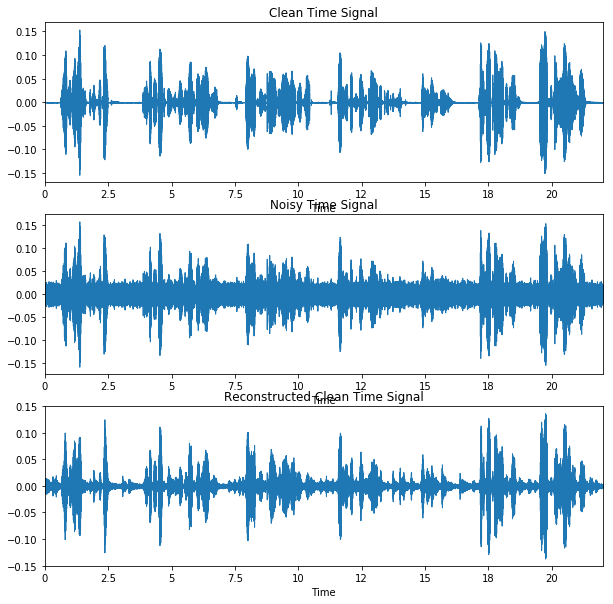

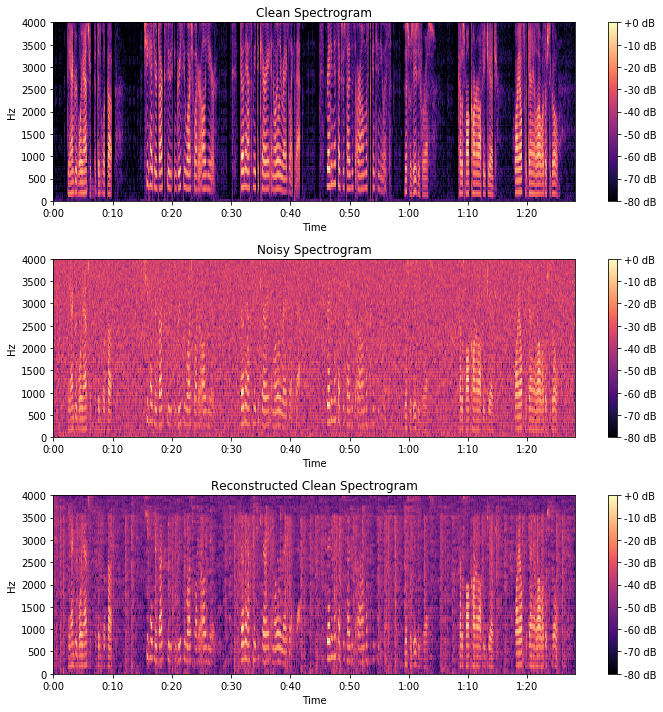

In [25]:
# Plot output waveform and spectrogram
show_signal(speech_clean,speech_noise,x_hat,Fs)
show_spectrogram(speech_clean,speech_noise,x_hat,Fs,NFFT,hop_size)